In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, \
    RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

In [2]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [4]:
train_data = pd.read_csv("../input/titanic/train.csv")
test_data = pd.read_csv("../input/titanic/test.csv")
combine = [train_data, test_data]

In [5]:
# Check data
train_data = train_data.fillna(np.nan)

missing_values_count = train_data.isnull().sum()
print(missing_values_count)

total_cells = np.product(train_data.shape)
total_missing = missing_values_count.sum()

percent_missing = (total_missing/total_cells) * 100
print("Percent of missing values: ", percent_missing)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Percent of missing values:  8.099513655069211




Feature analysis




Numerical variables


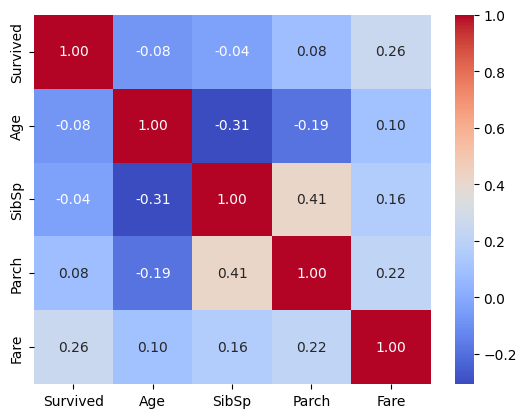

In [6]:
g = sns.heatmap(train_data[['Survived', 'Age', 'SibSp', 'Parch', 'Fare']].corr(), annot=True, fmt=".2f", cmap="coolwarm")

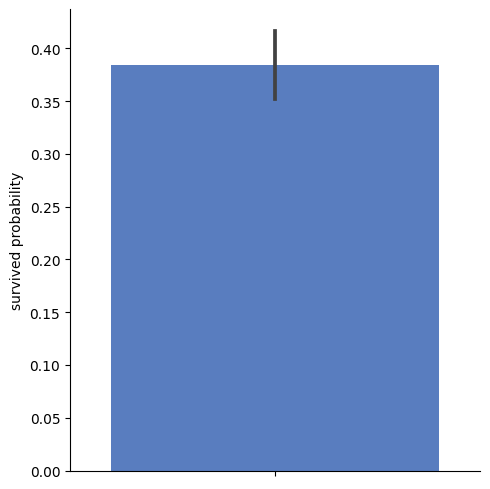

In [7]:
g = sns.catplot(hue="SibSp", y="Survived", data=train_data, kind="bar", palette="muted", legend=False)
g = g.set_ylabels("survived probability")

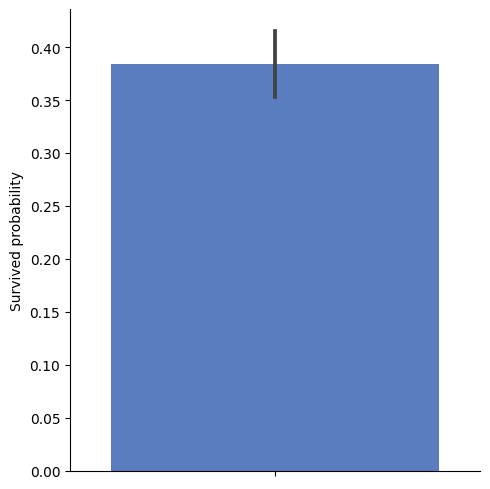

In [8]:
g = sns.catplot(hue="Parch", y="Survived", data=train_data, kind="bar", palette="muted", legend=False)
g = g.set_ylabels("Survived probability")

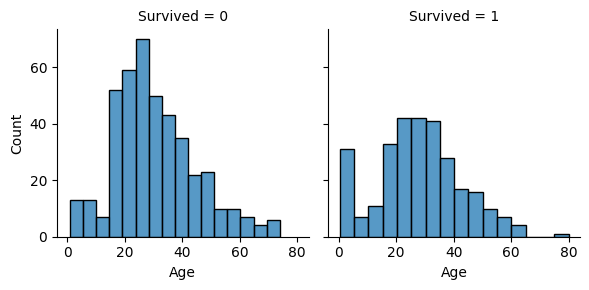

In [9]:
g = sns.FacetGrid(data=train_data, col="Survived")
g = g.map(sns.histplot, "Age")

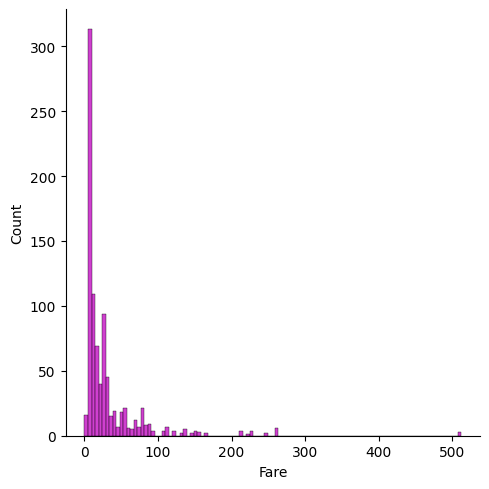

In [10]:
g = sns.displot(train_data["Fare"], color="m", label="Skewness: %.2f"%(train_data["Fare"].skew()))

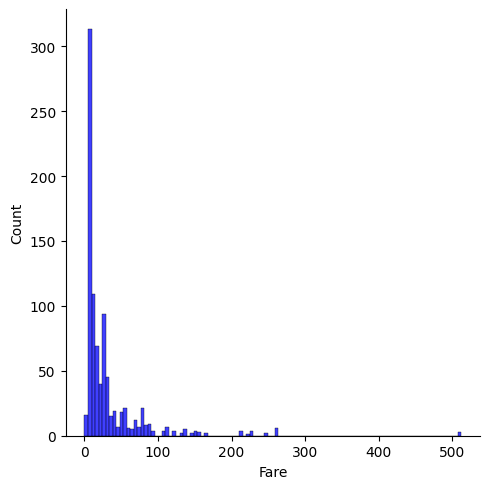

In [11]:
# Apply log to Fare to reduce skewness distribution
g = sns.displot(train_data["Fare"], color="b", label="Skewness: %.2f"%(train_data["Fare"].skew()))



Categorical variables


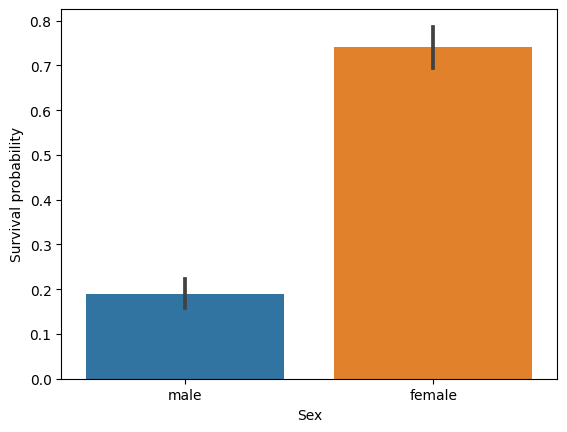

In [12]:
g = sns.barplot(x="Sex", y="Survived", data=train_data)
g = g.set_ylabel("Survival probability")

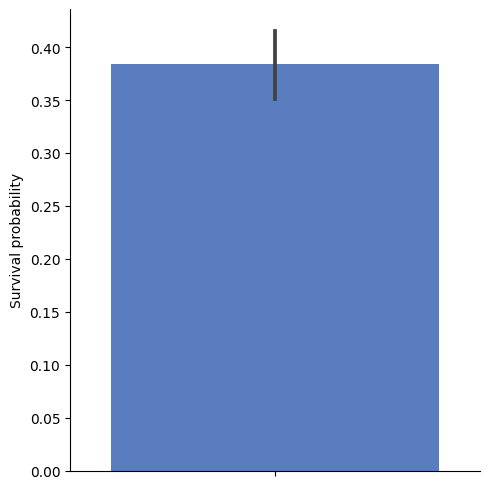

In [13]:
g = sns.catplot(hue="Pclass", y="Survived", data=train_data, kind="bar", palette="muted", legend=False)
g = g.set_ylabels("Survival probability")

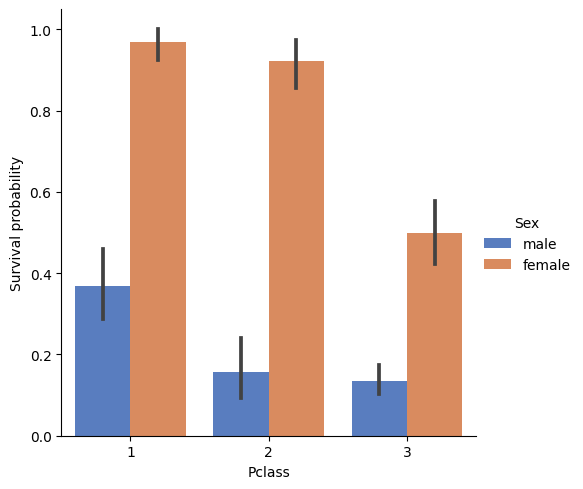

In [14]:
g = sns.catplot(x="Pclass", y="Survived", hue="Sex", data=train_data, kind="bar", palette="muted")
g = g.set_ylabels("Survival probability")

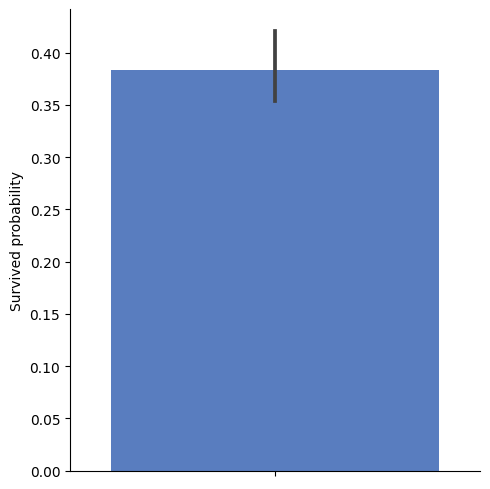

In [15]:
g = sns.catplot(hue="Embarked", y="Survived", data=train_data, kind="bar", palette="muted", legend=False)
g = g.set_ylabels("Survived probability")

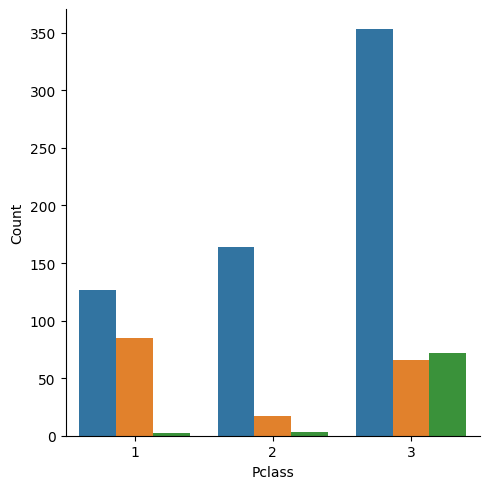

In [16]:
g = sns.catplot(x="Pclass", hue="Embarked", data=train_data, kind="count", legend=False)
g = g.set_ylabels("Count")

Preprocessing

In [17]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [18]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [19]:
print("B:", train_data.shape, test_data.shape, combine[0].shape, combine[1].shape)

train_data = train_data.drop(['Ticket', 'Cabin'], axis=1)
test_data = test_data.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_data, test_data]

print("A:", train_data.shape, test_data.shape, combine[0].shape, combine[1].shape)

B: (891, 12) (418, 11) (891, 12) (418, 11)
A: (891, 10) (418, 9) (891, 10) (418, 9)


In [20]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    
pd.crosstab(train_data['Title'], train_data['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [21]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_data[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [22]:
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in combine:
    dataset['Title'] = dataset['Title'].fillna(0)
    dataset['Title'] = dataset['Title'].map(titles)

In [23]:
print("B:", train_data.shape, test_data.shape, combine[0].shape, combine[1].shape)

PassengerId = test_data['PassengerId']
train_data = train_data.drop(['Name', 'PassengerId'], axis=1)
test_data = test_data.drop(['Name'], axis=1)
combine = [train_data, test_data]

print("A:", train_data.shape, test_data.shape, combine[0].shape, combine[1].shape)

B: (891, 11) (418, 10) (891, 11) (418, 10)
A: (891, 9) (418, 9) (891, 9) (418, 9)


In [24]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map({'male': 0, 'female': 1}).astype(int)

In [25]:
guess_ages = np.zeros((2,3))
guess_ages

for dataset in combine:
    for i in range(2):
        for j in range(3):
            guess_ds = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna()
            age_guess = guess_ds.median()
            
            guess_ages[i, j] = int(age_guess / .5 + .5) * .5
            
    for i in range(2):
        for j in range(3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1), 'Age'] = guess_ages[i,j]
            
    dataset['Age'] = dataset['Age'].astype(int)

In [26]:
freq_port = train_data.Embarked.dropna().mode()[0]

for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

In [27]:
for dataset in combine:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [28]:
freq_f = test_data.Fare.dropna().mode()[0]

for dataset in combine:
    dataset['Fare'] = dataset['Fare'].fillna(freq_f)

In [29]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

In [30]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

In [31]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

In [32]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

In [33]:
train_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone
0,0,3,0,1,1,0,0,0,1,2,0
1,1,1,1,2,1,0,3,1,3,2,0
2,1,3,1,1,0,0,1,0,2,1,1
3,1,1,1,2,1,0,3,0,3,2,0
4,0,3,0,2,0,0,1,0,1,1,1


In [34]:
test_data.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone
0,892,3,0,2,0,0,0,2,1,1,1
1,893,3,1,2,1,0,0,0,3,2,0
2,894,2,0,3,0,0,1,2,1,1,1
3,895,3,0,1,0,0,1,0,1,1,1
4,896,3,1,1,1,1,1,0,3,3,0


Train model (validation)

In [35]:
X_train, X_test, y_train, y_test = \
    train_test_split(train_data.drop("Survived", axis=1), train_data["Survived"], test_size=0.25, random_state=42)

X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train.shape, X_test.shape, X_val.shape

((501, 10), (223, 10), (167, 10))

In [36]:
clf1 = DecisionTreeClassifier(random_state=42)
clf2 = DecisionTreeClassifier(random_state=42, max_depth=1)
clf3 = DecisionTreeClassifier(random_state=42, max_depth=3)
eclf = VotingClassifier(estimators=[('dt0', clf1), ('dt1', clf2), ('dt2', clf3)], voting='hard')

labels = ['Classifier 1', 'Classifier 2', 'Classifier 3', 'Ensemble']
for clf, label in zip([clf1, clf2, clf3, eclf], labels):
    clf.fit(X_train, y_train)
    print("validaion Acc: %0.2f [%s]" % (clf.score(X_val, y_val), label))
    
print("Test Acc: %0.2f" % eclf.score(X_test, y_test))

validaion Acc: 0.78 [Classifier 1]
validaion Acc: 0.80 [Classifier 2]
validaion Acc: 0.84 [Classifier 3]
validaion Acc: 0.84 [Ensemble]
Test Acc: 0.83


In [37]:
X_train = train_data.drop("Survived", axis=1)
y_train = train_data["Survived"]
X_test = test_data.drop("PassengerId", axis=1).copy()
X_train.shape, y_train.shape, X_test.shape

((891, 10), (891,), (418, 10))

Train model

In [38]:
adaboost = AdaBoostClassifier()
adaboost.fit(X_train, y_train)
predictions = adaboost.predict(X_test)
round(adaboost.score(X_train, y_train) * 100, 2)

81.37

In [39]:
gradient_boosting = GradientBoostingClassifier()
gradient_boosting.fit(X_train, y_train)
predictions = gradient_boosting.predict(X_test)
round(gradient_boosting.score(X_train, y_train) * 100, 2)

85.86

In [40]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
predictions = random_forest.predict(X_test)
round(random_forest.score(X_train, y_train) * 100, 2)

89.0

In [41]:
k_neighbors = KNeighborsClassifier()
k_neighbors.fit(X_train, y_train)
predictions = k_neighbors.predict(X_test)
round(k_neighbors.score(X_train, y_train) * 100, 2)

84.62

In [42]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
predictions = decision_tree.predict(X_test)
round(decision_tree.score(X_train, y_train) * 100, 2)

89.0

In [43]:
extra_trees = ExtraTreesClassifier()
extra_trees.fit(X_train, y_train)
predictions = extra_trees.predict(X_test)
round(extra_trees.score(X_train, y_train) * 100, 2)

89.0

In [44]:
svm = SVC(probability=True, gamma='auto')
svm.fit(X_train, y_train)
predictions = svm.predict(X_test)
round(svm.score(X_train, y_train) * 100, 2)

83.61

In [45]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
predictions = xgb.predict(X_test)
round(xgb.score(X_train, y_train) * 100, 2)

88.44

Ensemble

In [46]:
random_forest_clf = RandomForestClassifier()
decision_tree_clf = DecisionTreeClassifier()
extra_trees_clf = ExtraTreesClassifier()

voting_clf = VotingClassifier(
    estimators=[('rf', random_forest_clf), ('df', decision_tree_clf), ('et', extra_trees_clf)], voting='hard'
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('df', DecisionTreeClassifier()),
                             ('et', ExtraTreesClassifier())])

Save predictions

In [47]:
test_Survived = pd.Series(voting_clf.predict(test_data.iloc[:, 1:]), name="Survived")

results = pd.concat([PassengerId[:len(test_Survived)],test_Survived],axis=1)

results.to_csv("results.csv",index=False)